## IMPORT NECCESSARY LIBRARY

In [2]:
import warnings 
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler , OneHotEncoder 
from sklearn.decomposition import PCA 

from tqdm import tqdm 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import TensorDataset , DataLoader 
from sklearn.model_selection import train_test_split 
import umap.umap_ as umap


## LOAD DATAFRAME 

In [3]:
# dataframe of anime information
df_anime = pd.read_csv('/kaggle/input/new-rec/data_anime (2).csv')
df_anime = df_anime.dropna()
df_anime = df_anime[~df_anime.isin(['unknown', 'unknow']).any(axis=1)]

df_rating = pd.read_csv('/kaggle/input/new-rec/data_rating (2).csv')

In [4]:
df_rating.shape 

(5932448, 3)

## EVALUATION METRIC FUNCTION

In [5]:

def ndcg_at_k(y_true, y_pred, k):
    """
    y_true: list hoặc set item relevant
    y_pred: list item được rank (giảm dần theo score)
    """
    if len(y_true) == 0:
        return 0.0

    y_true = set(y_true)
    y_pred_k = y_pred[:k]

    # DCG
    dcg = 0.0
    for i, item in enumerate(y_pred_k):
        if item in y_true:
            dcg += 1.0 / np.log2(i + 2)

    # IDCG
    ideal_hits = min(len(y_true), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(ideal_hits))

    return dcg / idcg if idcg > 0 else 0.0

In [6]:
def precision_at_k(y_true, y_pred, k):
    top_k = y_pred[:k]
    hit = len(set(top_k) & set(y_true))

    return hit / k if k > 0 else 0.0

In [7]:
def average_precision_at_k(y_true, y_pred, k):
    if len(y_true) == 0:
        return 0.0

    score = 0.0
    hits = 0
    y_true = set(y_true)

    for i, item in enumerate(y_pred[:k], start=1):
        if item in y_true:
            hits += 1
            score += hits / i

    return score / min(len(y_true), k)


## VISUALIZEITON FUNCTION

In [8]:
def visualize_embeddings_2D(df_embedding, title_prefix = "Embedding"):

    X = np.vstack(df_embedding["embedding"].values)

    #  PCA Visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(7, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=10)
    plt.title(f"{title_prefix} - PCA 2D")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(alpha=0.3)
    plt.show()

    print("→ PCA explained variance ratio:", pca.explained_variance_ratio_)

    #  UMAP Visualization 
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
    X_umap = reducer.fit_transform(X)

    plt.figure(figsize=(7, 6))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, s=10)
    plt.title(f"{title_prefix} - UMAP 2D")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(alpha=0.3)
    plt.show()
    
    print("Visualization complete.")

In [9]:
def visualize_embeddings_3D(df_embedding, title_prefix="Embeddings"):
    X = np.vstack(df_embedding["embedding"].values)

    # PCA 3D
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        s=12, alpha=0.65
    )
    ax.set_title(f"{title_prefix} - PCA 3D")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    plt.show()

    print("→ PCA explained variance ratio:", pca.explained_variance_ratio_)

    #  UMAP 3D
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=3,
        metric="cosine"
        )
    X_umap = reducer.fit_transform(X)

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        X_umap[:, 0], X_umap[:, 1], X_umap[:, 2],
        s=12, alpha=0.65
    )
    ax.set_title(f"{title_prefix} - UMAP 3D")
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")

    plt.show()

    print("Visualization 3D complete.")

## COLABORATIVE-FILTERING METHOD

### Data processing

In [10]:
min_rating = min(df_rating['rating'])
max_rating = max(df_rating['rating'])
df_rating['rating'] = df_rating["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(df_rating['rating'])
print('Avg', AvgRating)

Avg 0.6659294592871086


In [11]:
pd.crosstab(df_rating['user_id'], df_rating['anime_id'], df_rating['rating'], aggfunc = np.sum)

anime_id,1,5,6,7,8,15,16,17,18,19,...,43349,43555,43568,43690,44059,44087,45598,45753,47398,47616
user_id,,,,,,,,,,,,,,,,,,,,,
326,1.000000,1.000000,0.777778,0.777778,NaN,0.777778,0.777778,NaN,0.888889,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,0.666667,0.666667,0.666667,NaN,NaN,0.666667,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,NaN,NaN,NaN,0.444444,NaN,0.777778,0.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
781,0.666667,NaN,1.000000,1.000000,NaN,NaN,0.666667,NaN,0.777778,1.000000,...,0.555556,NaN,0.555556,NaN,0.444444,NaN,NaN,NaN,0.555556,NaN
853,0.888889,1.000000,0.777778,0.666667,NaN,0.888889,NaN,0.777778,0.888889,0.777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352924,1.000000,0.888889,0.777778,0.666667,NaN,NaN,0.666667,NaN,0.777778,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352930,1.000000,0.666667,1.000000,NaN,NaN,0.777778,0.888889,0.777778,0.777778,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
users_id = df_rating['user_id'].unique().tolist() 
items_id = df_rating['anime_id'].unique().tolist() 

user2user_encoded = {x : i for  i , x in enumerate(users_id)}
user_encoded2user = {i : x for i , x in enumerate(users_id)}

item2item_encoded = {x : i for i , x in enumerate(items_id)}
item_encoded2item = {i : x for i , x in enumerate(items_id)}

In [13]:
df_rating['user'] = df_rating['user_id'].map(user2user_encoded)
df_rating['anime'] = df_rating['anime_id'].map(item2item_encoded)

In [14]:
def pred_and_label(user_id, df_test, model, k=10, threshold=7):
    device = next(model.parameters()).device

    # Ground truth: item user thích (explicit rating)
    label = df_test[
        (df_test.user_id == user_id) &
        (df_test.rating >= (threshold - 1)/9)
    ]['anime_id'].unique().tolist()

    if len(label) == 0:
        return [], []

    # Candidate items
    all_items = df_test['anime_id'].unique().tolist()

    user_idx = user2user_encoded[user_id]
    item_idxs = torch.tensor(
        [item2item_encoded[i] for i in all_items],
        device=device
    )

    user_tensor = torch.full_like(item_idxs, user_idx)

    scores = model(user_tensor, item_idxs).squeeze()
    
    topk_idx = torch.topk(scores, k).indices.cpu().numpy()
    pred = [all_items[i] for i in topk_idx]

    return pred, label



In [15]:
# eval function
def evaluate_model(df_test, model, k=10):
    total_ndcg = 0
    total_precision = 0
    total_map = 0
    count = 0

    for user_id in df_test['user_id'].unique():
        pred, label = pred_and_label(user_id, df_test, model, k)

        if len(pred) == 0 or len(label) == 0:
            continue

        count += 1
        total_ndcg += ndcg_at_k(label, pred, k)
        total_precision += precision_at_k(label, pred, k)
        total_map += average_precision_at_k(label, pred, k)

    return {
        "ndcg@10": total_ndcg / count,
        "precision@10": total_precision / count,
        "map@10": total_map / count,
        "num_users": count
    }


In [16]:
# train test slip 
def split_by_user(df, train_ratio=0.8, val_ratio=0.7, seed=42):
    train_list, val_list, test_list = [], [], []

    for user, group in df.groupby("user_id"):
        if len(group) <= 3: 
            train_list.append(group)
            continue

        train, temp = train_test_split(
            group, test_size=1-train_ratio, random_state=seed
        )
        try: 
            val, test = train_test_split(
                temp, test_size=1 - val_ratio, random_state=seed
            )
        except:
            test = temp

        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    return (
        pd.concat(train_list),
        pd.concat(val_list),
        pd.concat(test_list)
    )



In [17]:
# data loader
class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.users = torch.LongTensor(df.user.values)
        self.items = torch.LongTensor(df.anime.values)
        self.ratings = torch.FloatTensor(df.rating.values)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

### 1. SVD 

In [18]:
df_train, df_val, df_test = split_by_user(df_rating, val_ratio = 0.5)


In [20]:
print(df_train.shape, df_test.shape, df_val.shape)

(4744171, 5) (595244, 5) (593161, 5)


In [21]:
# create data loader
train_loader = DataLoader(RatingDataset(df_train), batch_size=1024, shuffle=True)
val_loader   = DataLoader(RatingDataset(df_val), batch_size=2048)


In [22]:
# model 
class SVD(nn.Module):
    def __init__(self, num_users, num_items, dim, global_mean):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, dim)
        self.item_emb = nn.Embedding(num_items, dim)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)
        self.global_mean = global_mean

        nn.init.normal_(self.user_emb.weight, std=0.1)
        nn.init.normal_(self.item_emb.weight, std=0.1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, users, items):
        return (
            self.global_mean
            + self.user_bias(users).squeeze()
            + self.item_bias(items).squeeze()
            + (self.user_emb(users) * self.item_emb(items)).sum(dim=1)
        )


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SVD(
    num_users=len(user2user_encoded),
    num_items=len(item2item_encoded),
    dim= 32,
    global_mean=df_train.rating.mean()
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
reg_lambda = 2e-2
best_val_rmse = float("inf")
def svd_loss(pred, rating, model, reg_lambda):
    mse = torch.mean((pred - rating) ** 2)

    reg = (
        model.user_emb.weight.norm(2) ** 2
        + model.item_emb.weight.norm(2) ** 2
        + model.user_bias.weight.norm(2) ** 2
        + model.item_bias.weight.norm(2) ** 2
    )

    return mse + reg_lambda * reg



In [22]:
# train loop 
epochs = 20
log = {'train_loss': [], 'val_loss': []}
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for u, i, r in tqdm(train_loader):
        u, i, r = u.to(device), i.to(device), r.to(device)

        loss = svd_loss(model(u, i), r, model, reg_lambda)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(r)

    train_rmse = np.sqrt(total_loss / len(df_train))
    
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for u, i, r in tqdm(val_loader):
            u, i, r = u.to(device), i.to(device), r.to(device)
            p = model(u, i)
            preds.append(p.cpu())
            targets.append(r.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    val_rmse = torch.sqrt(((preds - targets) ** 2).mean()).item()

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train RMSE {train_rmse:.4f} | "
        f"Val RMSE {val_rmse:.4f}"
    )
    log['train_loss'].append(train_rmse)
    log['val_loss'].append(val_rmse)
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), "best_svd.pt")


100%|██████████| 290/290 [00:05<00:00, 54.72it/s]


Epoch 01 | Train RMSE 0.1412 | Val RMSE 0.1278


100%|██████████| 290/290 [00:05<00:00, 51.43it/s]


Epoch 02 | Train RMSE 0.1224 | Val RMSE 0.1226


100%|██████████| 290/290 [00:05<00:00, 51.82it/s]


Epoch 03 | Train RMSE 0.1178 | Val RMSE 0.1214


100%|██████████| 290/290 [00:05<00:00, 48.57it/s]


Epoch 04 | Train RMSE 0.1160 | Val RMSE 0.1210


100%|██████████| 290/290 [00:05<00:00, 54.37it/s]


Epoch 05 | Train RMSE 0.1151 | Val RMSE 0.1208


100%|██████████| 290/290 [00:05<00:00, 51.91it/s]


Epoch 06 | Train RMSE 0.1146 | Val RMSE 0.1207


100%|██████████| 290/290 [00:05<00:00, 51.14it/s]


Epoch 07 | Train RMSE 0.1142 | Val RMSE 0.1207


100%|██████████| 290/290 [00:06<00:00, 48.10it/s]


Epoch 08 | Train RMSE 0.1140 | Val RMSE 0.1207


100%|██████████| 290/290 [00:05<00:00, 51.36it/s]


Epoch 09 | Train RMSE 0.1138 | Val RMSE 0.1207


100%|██████████| 290/290 [00:05<00:00, 50.44it/s]


Epoch 10 | Train RMSE 0.1137 | Val RMSE 0.1207


100%|██████████| 290/290 [00:06<00:00, 45.03it/s]


Epoch 11 | Train RMSE 0.1136 | Val RMSE 0.1208


100%|██████████| 290/290 [00:05<00:00, 50.77it/s]


Epoch 12 | Train RMSE 0.1135 | Val RMSE 0.1208


100%|██████████| 290/290 [00:05<00:00, 51.31it/s]


Epoch 13 | Train RMSE 0.1135 | Val RMSE 0.1208


100%|██████████| 290/290 [00:05<00:00, 51.45it/s]


Epoch 14 | Train RMSE 0.1134 | Val RMSE 0.1208


100%|██████████| 290/290 [00:06<00:00, 46.10it/s]


Epoch 15 | Train RMSE 0.1134 | Val RMSE 0.1209


100%|██████████| 290/290 [00:05<00:00, 51.28it/s]


Epoch 16 | Train RMSE 0.1133 | Val RMSE 0.1209


100%|██████████| 290/290 [00:05<00:00, 51.18it/s]


Epoch 17 | Train RMSE 0.1133 | Val RMSE 0.1209


100%|██████████| 290/290 [00:05<00:00, 51.91it/s]


Epoch 18 | Train RMSE 0.1133 | Val RMSE 0.1210


100%|██████████| 290/290 [00:05<00:00, 51.52it/s]


Epoch 19 | Train RMSE 0.1132 | Val RMSE 0.1209


100%|██████████| 290/290 [00:05<00:00, 51.85it/s]

Epoch 20 | Train RMSE 0.1132 | Val RMSE 0.1209


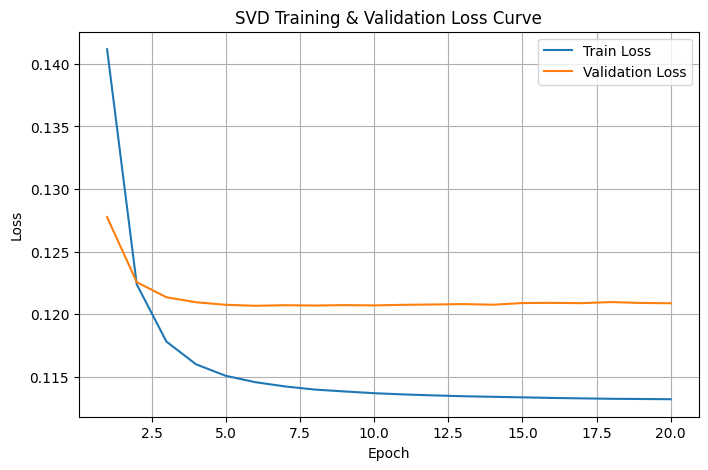

In [23]:
train_loss = log['train_loss']
val_loss = log['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SVD Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
 # evaluation model 
with torch.no_grad():
    for k in [10,20,40]:
        res = evaluate_model(df_test, model, k = k)
        print(res)

{'ndcg@10': np.float64(0.057767035815967684), 'precision@10': 0.058290329818261905, 'map@10': 0.019611769370575745, 'num_users': 4457}
{'ndcg@10': np.float64(0.05766214113331612), 'precision@10': 0.05749382993044752, 'map@10': 0.013643120221179642, 'num_users': 4457}
{'ndcg@10': np.float64(0.05807224304243124), 'precision@10': 0.056450527260489755, 'map@10': 0.009903926214457332, 'num_users': 4457}


In [25]:
# visualization the user embedding and itemt embedding 
user_embeddings = pd.DataFrame({
    "user_id": df_rating['user_id'].unique(),
    "embedding": model.user_emb.weight.tolist()})

item_embeddings = pd.DataFrame({
    "anime_id": df_rating['anime_id'].unique(),
    "embedding": model.item_emb.weight.tolist()})

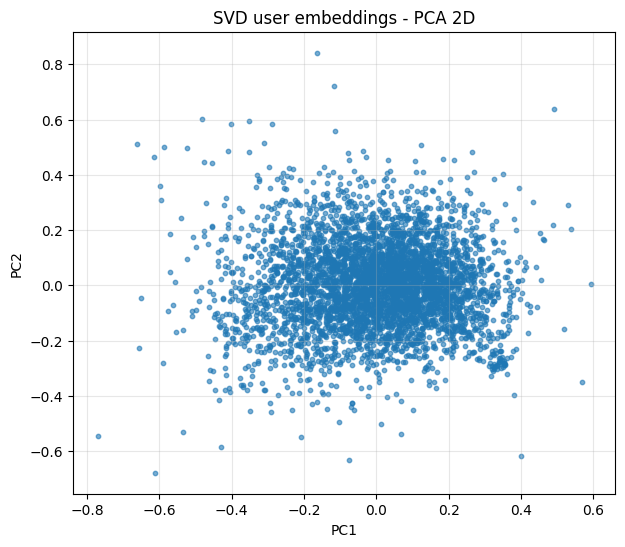

→ PCA explained variance ratio: [0.09629925 0.07041604]


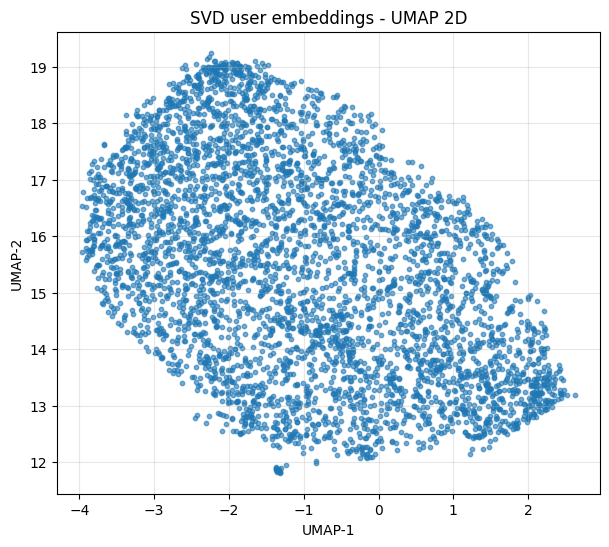

Visualization complete.


In [26]:
visualize_embeddings_2D(user_embeddings, "SVD user embeddings")

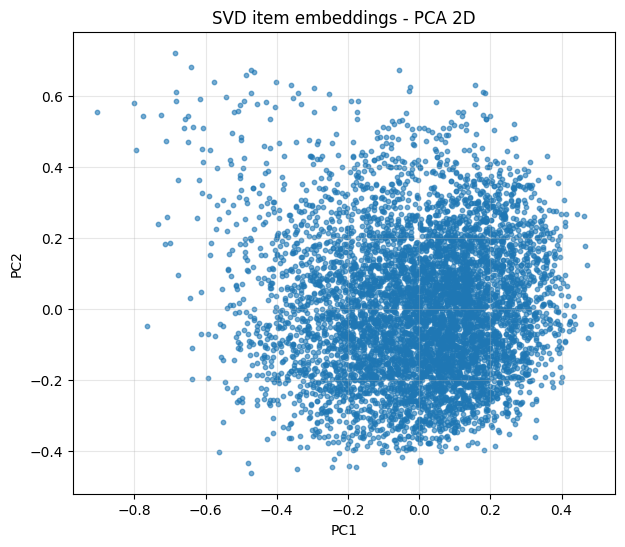

→ PCA explained variance ratio: [0.06260954 0.05848964]


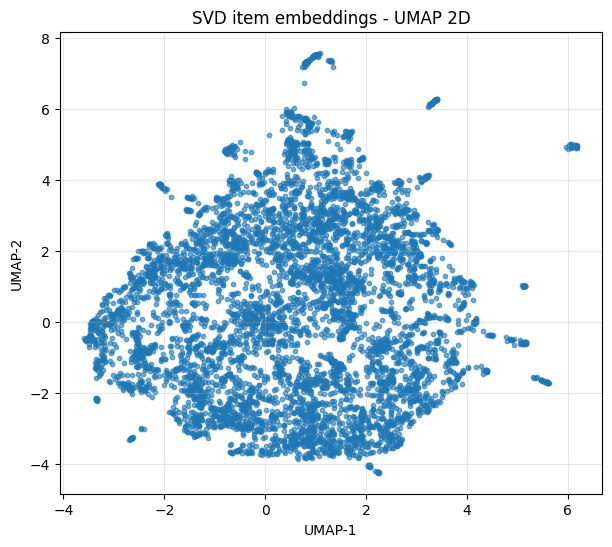

Visualization complete.


In [27]:
visualize_embeddings_2D(item_embeddings, "SVD item embeddings")

### 2. SVD++

In [28]:
from collections import defaultdict

df_train,df_test,df_val = split_by_user(df_rating, train_ratio = 0.3, val_ratio = 0.7)
user_items = defaultdict(list)

for u, i in zip(df_train.user, df_train.anime):
    user_items[u].append(i)


In [29]:
# data loader 
train_loader = DataLoader(RatingDataset(df_train), batch_size=1024, shuffle=True)
val_loader   = DataLoader(RatingDataset(df_val[:10000]), batch_size=2048)

In [30]:
# model 
class SVDpp(nn.Module):
    def __init__(self, num_users, num_items, dim, global_mean, user_items):
        super().__init__()

        self.user_emb = nn.Embedding(num_users, dim)
        self.item_emb = nn.Embedding(num_items, dim)
        self.implicit_emb = nn.Embedding(num_items, dim)

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

        self.global_mean = global_mean
        self.user_items = user_items
        self.dim = dim

        nn.init.normal_(self.user_emb.weight, std=0.1)
        nn.init.normal_(self.item_emb.weight, std=0.1)
        nn.init.normal_(self.implicit_emb.weight, std=0.1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, users, items):
        device = users.device
        batch_size = users.size(0)

        p_u = self.user_emb(users)
        q_i = self.item_emb(items)

        # implicit sum
        y_sum = torch.zeros(batch_size, self.dim, device=device)

        for idx, u in enumerate(users):
            items_u = self.user_items[int(u)]
            if len(items_u) > 0:
                items_u = torch.LongTensor(items_u).to(device)
                y = self.implicit_emb(items_u)
                y_sum[idx] = y.mean(dim=0)

        b_u = self.user_bias(users).squeeze()
        b_i = self.item_bias(items).squeeze()

        return (
            self.global_mean
            + b_u + b_i
            + (q_i * (p_u + y_sum)).sum(dim=1)
        )


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SVDpp(
    num_users=len(user2user_encoded),
    num_items=len(item2item_encoded),
    dim=64,
    global_mean=df_train.rating.mean(),
    user_items=user_items
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()


In [32]:
# train loop 
epochs = 20
best_val_rmse = float("inf")
log = {'train_loss': [], 'val_loss': []}
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for u, i, r in tqdm(train_loader):
        u, i, r = u.to(device), i.to(device), r.to(device)

        loss = criterion(model(u, i), r)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(r)

    train_rmse = np.sqrt(total_loss / len(df_train))
    
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for u, i, r in tqdm(val_loader):
            u, i, r = u.to(device), i.to(device), r.to(device)
            p = model(u, i)
            preds.append(p.cpu())
            targets.append(r.cpu())

    preds = torch.cat(preds)
    targets = torch.cat(targets)

    val_rmse = torch.sqrt(((preds - targets) ** 2).mean()).item()

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train RMSE {train_rmse:.4f} | "
        f"Val RMSE {val_rmse:.4f}"
    )
    log['train_loss'].append(train_rmse)
    log['val_loss'].append(val_rmse)
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), "best_svdpp.pt")


100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


Epoch 01 | Train RMSE 0.1503 | Val RMSE 0.1423


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch 02 | Train RMSE 0.1339 | Val RMSE 0.1398


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Epoch 03 | Train RMSE 0.1329 | Val RMSE 0.1396


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 04 | Train RMSE 0.1328 | Val RMSE 0.1391


100%|██████████| 5/5 [00:01<00:00,  3.29it/s]


Epoch 05 | Train RMSE 0.1327 | Val RMSE 0.1392


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 06 | Train RMSE 0.1326 | Val RMSE 0.1396


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch 07 | Train RMSE 0.1325 | Val RMSE 0.1391


100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


Epoch 08 | Train RMSE 0.1324 | Val RMSE 0.1394


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 09 | Train RMSE 0.1323 | Val RMSE 0.1395


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Epoch 10 | Train RMSE 0.1323 | Val RMSE 0.1390


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 11 | Train RMSE 0.1322 | Val RMSE 0.1390


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 12 | Train RMSE 0.1321 | Val RMSE 0.1391


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 13 | Train RMSE 0.1321 | Val RMSE 0.1386


100%|██████████| 5/5 [00:01<00:00,  3.33it/s]


Epoch 14 | Train RMSE 0.1321 | Val RMSE 0.1390


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 15 | Train RMSE 0.1321 | Val RMSE 0.1387


100%|██████████| 5/5 [00:01<00:00,  3.31it/s]


Epoch 16 | Train RMSE 0.1320 | Val RMSE 0.1389


100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Epoch 17 | Train RMSE 0.1320 | Val RMSE 0.1388


100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Epoch 18 | Train RMSE 0.1320 | Val RMSE 0.1387


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch 19 | Train RMSE 0.1320 | Val RMSE 0.1389


100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

Epoch 20 | Train RMSE 0.1319 | Val RMSE 0.1387


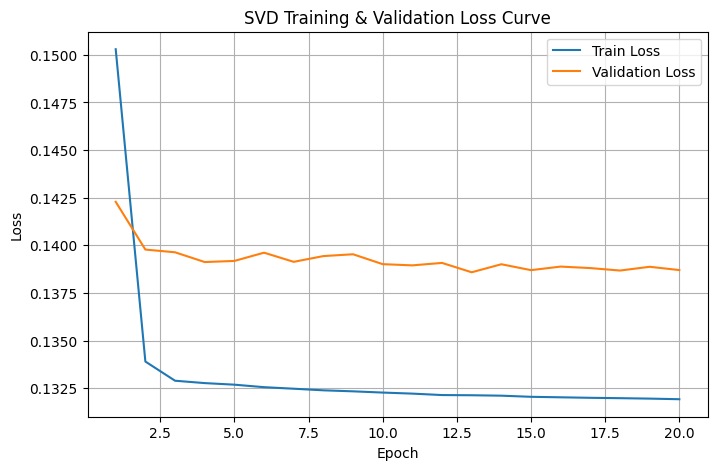

In [33]:

train_loss = log['train_loss']
val_loss = log['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SVD Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

**Evaluation**

In [34]:
# evaluation model 
with torch.no_grad():
    for k in [10,20,40]:
        res = evaluate_model(df_test, model, k)
        print(res)

{'ndcg@10': np.float64(0.27972505659420976), 'precision@10': 0.29219205743773774, 'map@10': 0.14374739574986328, 'num_users': 4457}
{'ndcg@10': np.float64(0.27866882537865645), 'precision@10': 0.2841934036347312, 'map@10': 0.1231940187313141, 'num_users': 4457}
{'ndcg@10': np.float64(0.26945367184931046), 'precision@10': 0.26830827911151006, 'map@10': 0.1040664767899776, 'num_users': 4457}


In [35]:
# visualization the user embedding and item embedding 
user_embeddings = pd.DataFrame({
    "user_id": df_rating['user_id'].unique(),
    "embedding": model.user_emb.weight.tolist()})

item_embeddings = pd.DataFrame({
    "anime_id": df_rating['anime_id'].unique(),
    "embedding": model.item_emb.weight.tolist()})

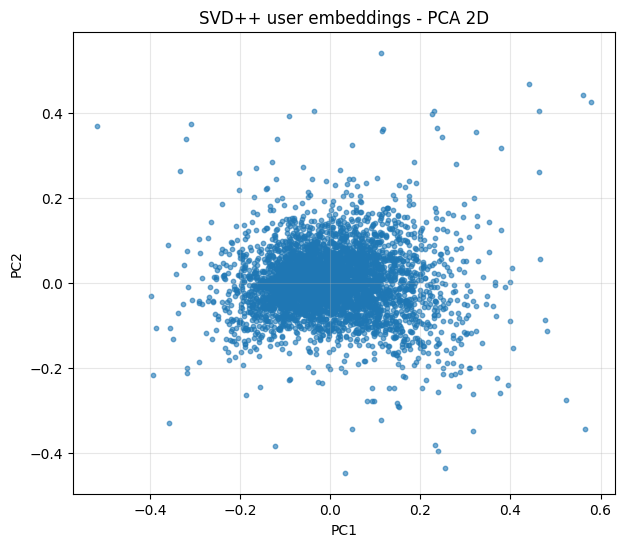

→ PCA explained variance ratio: [0.56441055 0.27419245]


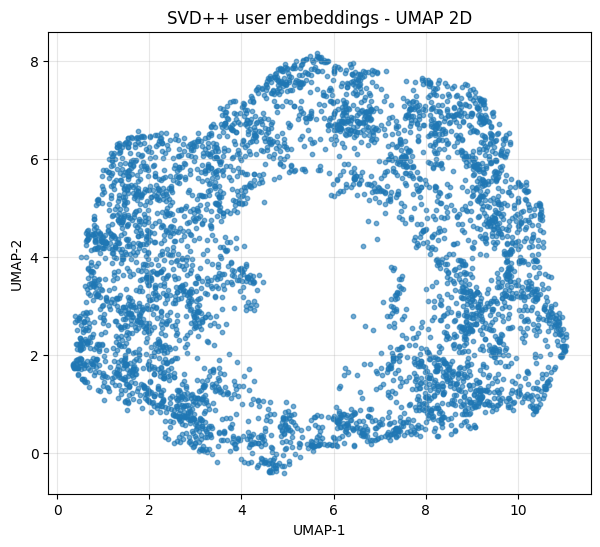

Visualization complete.


In [36]:
visualize_embeddings_2D(user_embeddings, "SVD++ user embeddings")

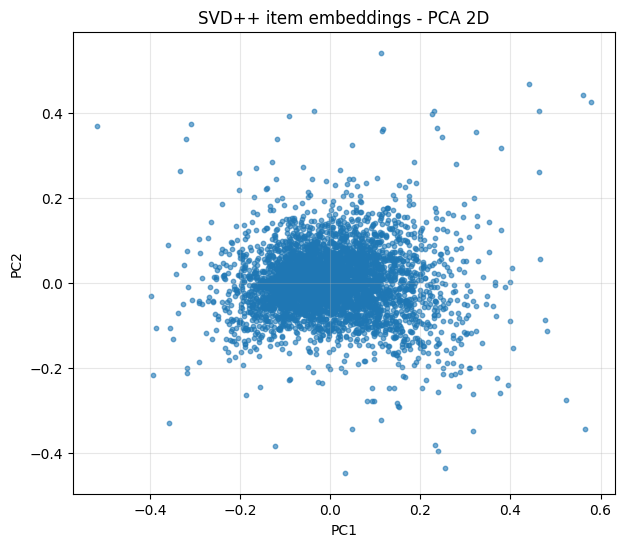

→ PCA explained variance ratio: [0.56441055 0.27419245]


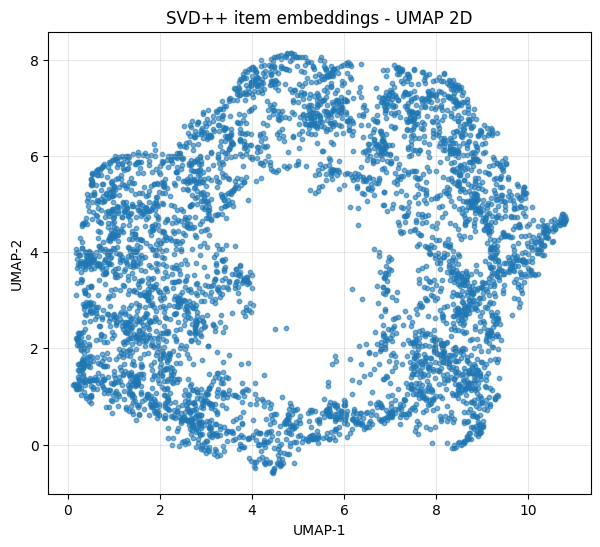

Visualization complete.


In [37]:
visualize_embeddings_2D(user_embeddings, "SVD++ item embeddings")

### 3. Neural Colaborative Filtering 

In [24]:
df_train, df_val, df_test = split_by_user(df_rating)


In [25]:
# create dataloader 
train_loader = DataLoader(RatingDataset(df_train), batch_size=1024, shuffle=True)
val_loader   = DataLoader(RatingDataset(df_val), batch_size=2048)


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(
        self,
        num_users,
        num_items,
        embedding_dim=64,
        hidden_dims=[128, 64, 32],
        dropout=0.2
    ):
        super().__init__()

        self.user_emb = nn.Embedding(num_users, embedding_dim)
        self.item_emb = nn.Embedding(num_items, embedding_dim)

        layers = []
        input_dim = embedding_dim * 2

        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = h

        self.mlp = nn.Sequential(*layers)
        self.output = nn.Linear(input_dim, 1)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)

        x = torch.cat([u, i], dim=1)
        x = self.mlp(x)
        rating = self.output(x)

        return rating.squeeze(1)


In [27]:
model = NCF(num_users = len(users_id), num_items = len(items_id))
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [28]:
model

NCF(
  (user_emb): Embedding(4459, 64)
  (item_emb): Embedding(6310, 64)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [29]:
from tqdm import tqdm 
# loop training 
log = {'train_loss': [], 'val_loss': []}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    loss_train = 0 

    for u, i, r in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        u , i , r = u.to(device) , i.to(device) , r.to(device)
        optimizer.zero_grad()

        preds = model(u , i)
        loss_step = loss(preds.view(-1), r.view(-1))

        loss_step.backward()
        optimizer.step()

        loss_train += loss_step.item()
    loss_val = 0
    model.eval()
    with torch.no_grad():
        for u , i, r in tqdm(val_loader,desc="Validating"):
            u , i , r = u.to(device) , i.to(device) , r.to(device)
            preds = model(u, i)
            loss_val_step = loss(preds.squeeze(), r).item()
            loss_val += loss_val_step 

    log['train_loss'].append(loss_train / len(train_loader))
    log['val_loss'].append(loss_val / len(val_loader))
    print(f'Epoch{epoch + 1} / {num_epochs}, loss_train: {loss_train / len(train_loader)} | loss_val: {loss_val / len(val_loader)}')

Validating: 100%|██████████| 406/406 [00:10<00:00, 39.79it/s]


Epoch1 / 20, loss_train: 0.02325357290532801 | loss_val: 0.018555334498509397


Validating: 100%|██████████| 406/406 [00:09<00:00, 41.17it/s]


Epoch2 / 20, loss_train: 0.018585143130398867 | loss_val: 0.018066967314503756


Validating: 100%|██████████| 406/406 [00:10<00:00, 40.41it/s]


Epoch3 / 20, loss_train: 0.01823470479541995 | loss_val: 0.017800790506639873


Validating: 100%|██████████| 406/406 [00:10<00:00, 40.59it/s]


Epoch4 / 20, loss_train: 0.01790949164737179 | loss_val: 0.017327310041446477


Validating: 100%|██████████| 406/406 [00:10<00:00, 40.46it/s]


Epoch5 / 20, loss_train: 0.017658372849472047 | loss_val: 0.01737008943094005


Validating: 100%|██████████| 406/406 [00:10<00:00, 40.59it/s]


Epoch6 / 20, loss_train: 0.017493794552986677 | loss_val: 0.01706389209778585


Validating: 100%|██████████| 406/406 [00:10<00:00, 39.59it/s]


Epoch7 / 20, loss_train: 0.017372516898718555 | loss_val: 0.01695291963612358


Validating: 100%|██████████| 406/406 [00:09<00:00, 41.40it/s]


Epoch8 / 20, loss_train: 0.017282941334629816 | loss_val: 0.01741111516181765


Validating: 100%|██████████| 406/406 [00:10<00:00, 39.70it/s]


Epoch9 / 20, loss_train: 0.0171899050381698 | loss_val: 0.017287332550828975


Validating: 100%|██████████| 406/406 [00:09<00:00, 40.77it/s]


Epoch10 / 20, loss_train: 0.017101860258220893 | loss_val: 0.016790705086122005


Validating: 100%|██████████| 406/406 [00:09<00:00, 40.87it/s]


Epoch11 / 20, loss_train: 0.017004097767452455 | loss_val: 0.016500797763861385


Validating: 100%|██████████| 406/406 [00:10<00:00, 40.08it/s]


Epoch12 / 20, loss_train: 0.016882355629267265 | loss_val: 0.016436819227990406


Validating: 100%|██████████| 406/406 [00:09<00:00, 40.77it/s]


Epoch13 / 20, loss_train: 0.016755781199975263 | loss_val: 0.016731935509668637


Validating: 100%|██████████| 406/406 [00:09<00:00, 41.03it/s]


Epoch14 / 20, loss_train: 0.01662942613041828 | loss_val: 0.016723009111965306


Validating: 100%|██████████| 406/406 [00:10<00:00, 39.18it/s]


Epoch15 / 20, loss_train: 0.01649449391183201 | loss_val: 0.016366227255822183


Validating: 100%|██████████| 406/406 [00:10<00:00, 39.17it/s]


Epoch16 / 20, loss_train: 0.016381314142126516 | loss_val: 0.016143584548234207


Validating: 100%|██████████| 406/406 [00:10<00:00, 39.58it/s]


Epoch17 / 20, loss_train: 0.016251397776256015 | loss_val: 0.016019898126122034


Validating: 100%|██████████| 406/406 [00:10<00:00, 39.81it/s]


Epoch18 / 20, loss_train: 0.016132794183086118 | loss_val: 0.016009364864362285


Validating: 100%|██████████| 406/406 [00:09<00:00, 40.77it/s]


Epoch19 / 20, loss_train: 0.016026607782939985 | loss_val: 0.016017765382515828


Validating: 100%|██████████| 406/406 [00:10<00:00, 39.64it/s]

Epoch20 / 20, loss_train: 0.015924724321245518 | loss_val: 0.015942518831015072


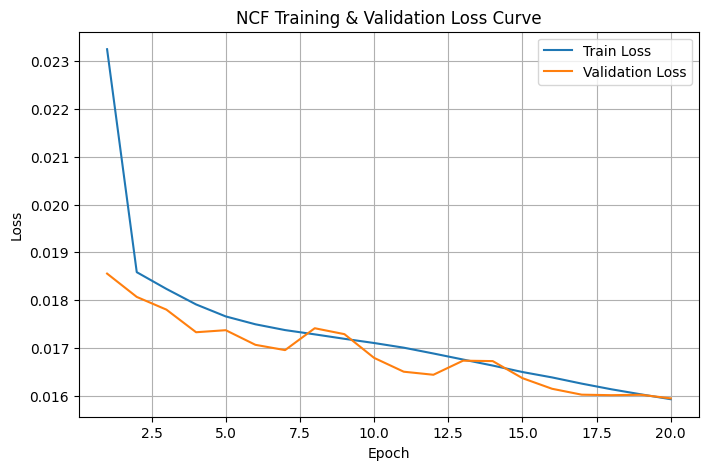

In [31]:
train_loss = log['train_loss']
val_loss = log['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NCF Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# save model 
torch.save(model.state_dict(),"model-NCF.pt") 

**Evaluation**

In [46]:
df_test.shape

(358937, 5)

In [32]:
# evaluation model 
with torch.no_grad():
    for k in [10,20,40]:
        res = evaluate_model(df_test, model, k)
        print(res)

{'ndcg@10': 0.03970750311874804, 'precision@10': 0.038882656495399584, 'map@10': 0.013170397368929396, 'num_users': 4457}
{'ndcg@10': 0.038727309630224055, 'precision@10': 0.03724478348665029, 'map@10': 0.00869151769445504, 'num_users': 4457}
{'ndcg@10': 0.03960824344611616, 'precision@10': 0.03537693515817904, 'map@10': 0.006259889806508738, 'num_users': 4457}


In [34]:
# visualization the user embedding and item embedding 
user_embeddings = pd.DataFrame({
    "user_id": df_rating['user_id'].unique(),
    "embedding": model.user_emb.weight.detach().cpu().tolist()})

item_embeddings = pd.DataFrame({
    "anime_id": df_rating['anime_id'].unique(),
    "embedding": model.item_emb.weight.detach().cpu().tolist()})

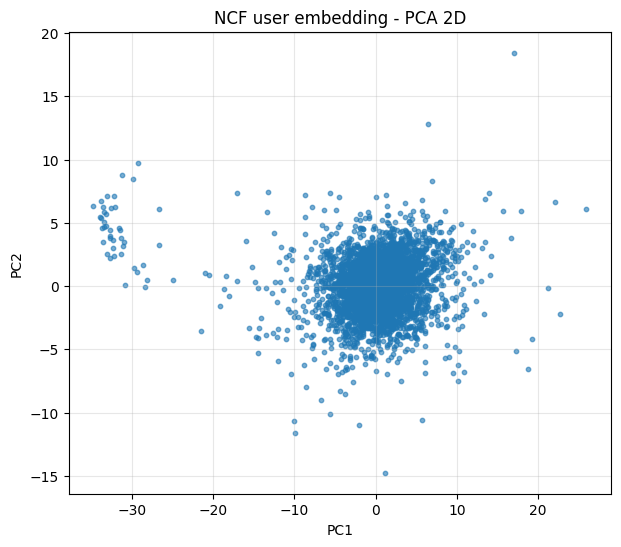

→ PCA explained variance ratio: [0.11917205 0.02447581]


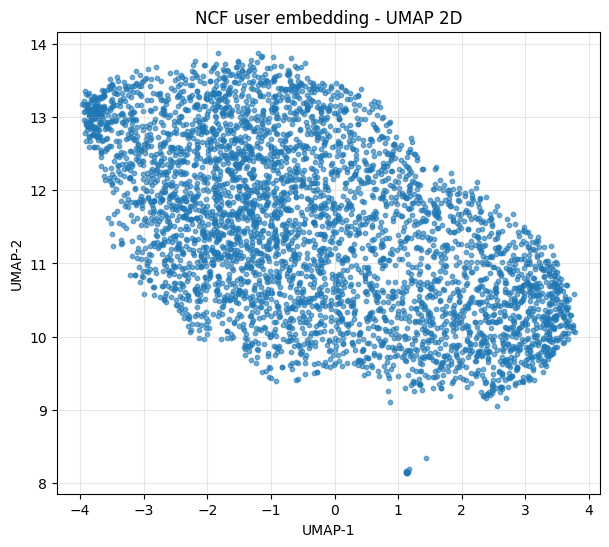

Visualization complete.


In [49]:
# visualization the user embedding and item emebdding 
visualize_embeddings_2D(user_embeddings, 'NCF user embedding')

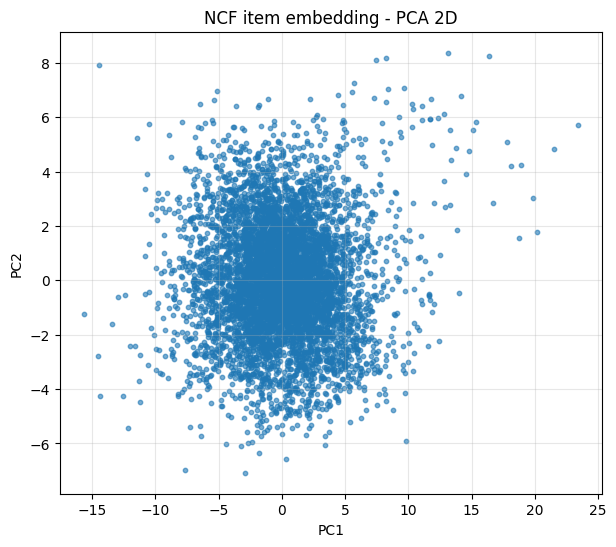

→ PCA explained variance ratio: [0.06150233 0.02162167]


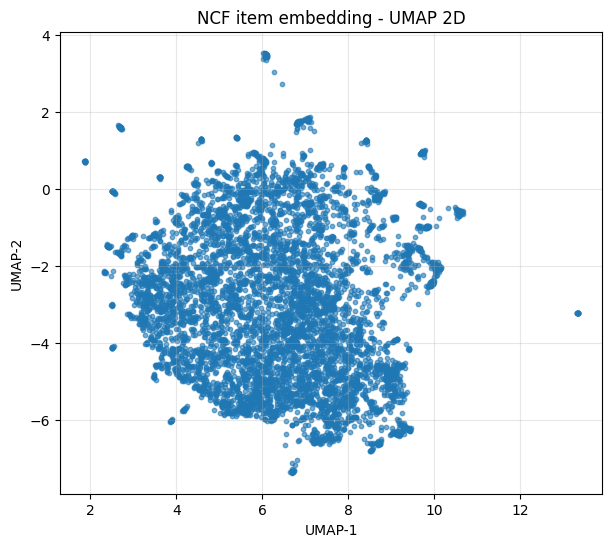

Visualization complete.


In [50]:
visualize_embeddings_2D(item_embeddings, "NCF item embedding")

### 4. LightGCL 

In [36]:
df_rating.head()

,user_id,anime_id,rating,user,anime
0,326,11061,0.888889,0,0
1,326,136,0.888889,0,1
2,326,10408,0.777778,0,2
3,326,256,0.777778,0,3
4,326,11005,0.777778,0,4


In [37]:
num_users = df_rating["user"].nunique()
num_items = df_rating["anime"].nunique()

df = df_rating[df_rating['rating'] >= (7 - 1)/9].copy() 
df_interaction = df[['user_id','anime_id',"user","anime",'rating']] 

In [38]:
df_interaction.shape

(3966366, 5)

In [39]:
df_train, df_val, df_test = split_by_user(df_interaction, train_ratio = 0.9,val_ratio = 0.3)

In [40]:
print(df_train.shape, df_val.shape, df_test.shape)

(3567749, 5) (117711, 5) (281040, 5)


In [41]:
# data loader 
val_loader   = DataLoader(RatingDataset(df_val), batch_size=1024)

In [42]:
import scipy.sparse as sp

rows = df_train["user"].values
cols = df_train["anime"].values + num_users
data = np.ones(len(df_train))

N = num_users + num_items
A = sp.coo_matrix((data, (rows, cols)), shape=(N, N))
A = A + A.T

In [43]:
def normalize_adj(A):
    deg = np.array(A.sum(1)).flatten()
    deg_inv_sqrt = np.power(deg, -0.5)
    deg_inv_sqrt[np.isinf(deg_inv_sqrt)] = 0
    D = sp.diags(deg_inv_sqrt)
    return D @ A @ D

A_norm = normalize_adj(A).tocsr()


In [44]:
# build adjacent matrix 
R = sp.coo_matrix(
    (np.ones(len(df_train)), (df_train["user"], df_train["anime"])),
    shape=(num_users, num_items)
).tocsr()


In [45]:
from sklearn.utils.extmath import randomized_svd

q = 5   # rank, paper dùng 5–10

U, S, Vt = randomized_svd(R, n_components=q, random_state=42)

# Shapes:
# U  : (num_users, q)
# S  : (q,)
# Vt : (q, num_items)

US = U * S                 # (num_users, q)
VS = Vt.T                  # (num_items, q)


In [46]:
# negative sampling for BPR 
import random
from collections import defaultdict

user_pos = defaultdict(set)
for u, i in zip(df_train["user"], df_train["anime"]):
    user_pos[u].add(i)

def sample_bpr(batch_size):
    users, pos_items, neg_items = [], [], []
    for _ in range(batch_size):
        u = random.choice(list(user_pos.keys()))
        i = random.choice(list(user_pos[u]))
        while True:
            j = random.randint(0, num_items - 1)
            if j not in user_pos[u]:
                break
        users.append(u)
        pos_items.append(i)
        neg_items.append(j)
    return users, pos_items, neg_items


**model**

In [47]:
def scipy_to_torch_sparse(mat):
    mat = mat.tocoo()
    indices = torch.LongTensor([mat.row, mat.col])
    values = torch.FloatTensor(mat.data)
    shape = mat.shape
    return torch.sparse_coo_tensor(indices, values, shape)


In [56]:
class LightGCL(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, A_norm, US, VS, device):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items

        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)

        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)

        self.A_norm = scipy_to_torch_sparse(A_norm).coalesce().to(device)

        self.US = torch.FloatTensor(US)
        self.VS = torch.FloatTensor(VS)

    def propagate_local(self):
        z0 = torch.cat([self.user_emb.weight,
                        self.item_emb.weight], dim=0)
        z1 = torch.sparse.mm(self.A_norm, z0)
        return z1[:self.num_users], z1[self.num_users:]

    def propagate_global(self):
        g_user = self.US @ (self.VS.T @ self.item_emb.weight)
        g_item = self.VS @ (self.US.T @ self.user_emb.weight)
        return g_user, g_item

    def info_nce(self, z, g, tau=0.5):
        z = F.normalize(z, dim=1)
        g = F.normalize(g, dim=1)
        sim = z @ g.T / tau
        labels = torch.arange(z.size(0), device=z.device)
        return F.cross_entropy(sim, labels)
        
    def predict_rating(self, users, items):
        z_u, z_i = self.propagate_local()   # embedding cuối
        return (z_u[users] * z_i[items]).sum(dim=1)


    def forward(self, users, pos_items, neg_items, cl_weight=2e-7):
        z_u, z_i = self.propagate_local()
        g_u, g_i = self.propagate_global()

        # BPR loss
        u = z_u[users]
        pos = z_i[pos_items]
        neg = z_i[neg_items]

        bpr = -torch.log(
            torch.sigmoid((u * pos).sum(1) - (u * neg).sum(1))
        ).mean()

        # Contrastive loss
        cl = self.info_nce(z_u, g_u) + self.info_nce(z_i, g_i)

        return bpr + cl_weight * cl


In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LightGCL(
    num_users,
    num_items,
    emb_dim=64,
    A_norm=A_norm,
    US=US,
    VS=VS, device = device
).to(device)

model.US = model.US.to(device)
model.VS = model.VS.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [65]:
epochs = 70
batch = 1024
best_val_rmse = float("inf")
log = {'constractive_loss': [], 'RMSE_loss': []}
for epoch in range(epochs):
    users, pos, neg = sample_bpr(batch)

    users = torch.LongTensor(users).to(device)
    pos = torch.LongTensor(pos).to(device)
    neg = torch.LongTensor(neg).to(device)

    loss = model(users, pos, neg)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        total_loss = 0
        for u, i, r in val_loader:
            users = torch.LongTensor(df_val.user.values).to(device)
            items = torch.LongTensor(df_val.anime.values).to(device)
            ratings = torch.FloatTensor(df_val.rating.values).to(device)
        
            preds = model.predict_rating(users, items)
            mse = F.mse_loss(preds, ratings)
            rmse = torch.sqrt(mse)
            total_loss += rmse.item()
    val_rmse = total_loss/len(val_loader)
    if val_rmse < best_val_rmse:
        torch.save(model.state_dict(),'LightGCL.pt')
    log['constractive_loss'].append(loss.item())
    log['RMSE_loss'].append(total_loss/len(val_loader))
    print(f"Epoch {epoch:03d} | Loss {loss.item():.4f} | Val RMSE: {val_rmse}")



Epoch 000 | Loss 0.6931 | Val RMSE: 0.7811818718910217
Epoch 001 | Loss 0.6931 | Val RMSE: 0.7811346054077148
Epoch 002 | Loss 0.6931 | Val RMSE: 0.7810337543487549
Epoch 003 | Loss 0.6931 | Val RMSE: 0.780865490436554
Epoch 004 | Loss 0.6931 | Val RMSE: 0.7806165814399719
Epoch 005 | Loss 0.6930 | Val RMSE: 0.7802726626396179
Epoch 006 | Loss 0.6929 | Val RMSE: 0.7798225283622742
Epoch 007 | Loss 0.6928 | Val RMSE: 0.7792555689811707
Epoch 008 | Loss 0.6927 | Val RMSE: 0.7785635590553284
Epoch 009 | Loss 0.6926 | Val RMSE: 0.7777386903762817
Epoch 010 | Loss 0.6924 | Val RMSE: 0.7767708897590637
Epoch 011 | Loss 0.6922 | Val RMSE: 0.7756513953208923
Epoch 012 | Loss 0.6919 | Val RMSE: 0.7743721008300781
Epoch 013 | Loss 0.6917 | Val RMSE: 0.7729257941246033
Epoch 014 | Loss 0.6913 | Val RMSE: 0.771304190158844
Epoch 015 | Loss 0.6911 | Val RMSE: 0.7695019841194153
Epoch 016 | Loss 0.6906 | Val RMSE: 0.7675134539604187
Epoch 017 | Loss 0.6902 | Val RMSE: 0.7653302550315857
Epoch 018 | 

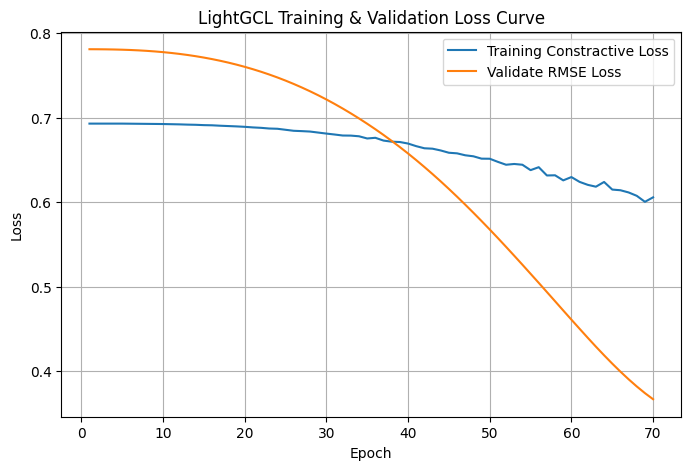

In [72]:
train_loss = log['constractive_loss']
val_loss = log['RMSE_loss']
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Training Constractive Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validate RMSE Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LightGCL Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

**Evaluation**

In [61]:
@torch.no_grad()
def recommend(user_id,model, K=10):
    u = user2user_encoded[user_id]

    z_u, z_i = model.propagate_local()
    scores = (z_u[u] @ z_i.T).cpu().numpy()

    scores[list(user_pos[u])] = -1e9
    topk = scores.argsort()[-K:][::-1]

    return [item_encoded2item[iid] for iid in topk]

In [62]:

def evaluate_topk(
    df_test,
    model,
    k=10,
    rating_threshold=7
):
    
    item_set = set(df_test["anime_id"].unique())

    user_pos = (
        df_test[df_test["rating"] >= (rating_threshold-1)/9]
        .groupby("user_id")["anime_id"]
        .apply(lambda x: list(set(x) & item_set))
        .to_dict()
    )

    total_ndcg = 0.0
    total_precision = 0.0
    total_map = 0.0
    count = 0

    for user_id, label in user_pos.items():

        if len(label) == 0:
            continue

        pred = recommend(user_id,model)

        if pred is None or len(pred) == 0:
            continue

        count += 1
        total_ndcg += ndcg_at_k(label, pred, k)
        total_precision += precision_at_k(label, pred, k)
        total_map += average_precision_at_k(label, pred, k)

    return {
        f"ndcg@{k}": total_ndcg / count,
        f"precision@{k}": total_precision / count,
        f"map@{k}": total_map / count
    }


In [68]:
with torch.no_grad():
    for k in [10,20,40]:
        res = evaluate_topk(df_test,model,k = k)
        print(res)

{'ndcg@10': 0.6151306256990497, 'precision@10': 0.6144716176800572, 'map@10': 0.6099063894498054}
{'ndcg@20': 0.5896639195259057, 'precision@20': 0.5723580884002862, 'map@20': 0.5706350982806463}
{'ndcg@40': 0.5712412484875248, 'precision@40': 0.5536179044200144, 'map@40': 0.5312770885112469}


In [70]:
# visualization the user embedding and item embedding 
user_embeddings = pd.DataFrame({
    "user_id": df_rating['user_id'].unique(),
    "embedding": model.user_emb.weight.detach().cpu().tolist()})

item_embeddings = pd.DataFrame({
    "anime_id": df_rating['anime_id'].unique(),
    "embedding": model.item_emb.weight.detach().cpu().tolist()})

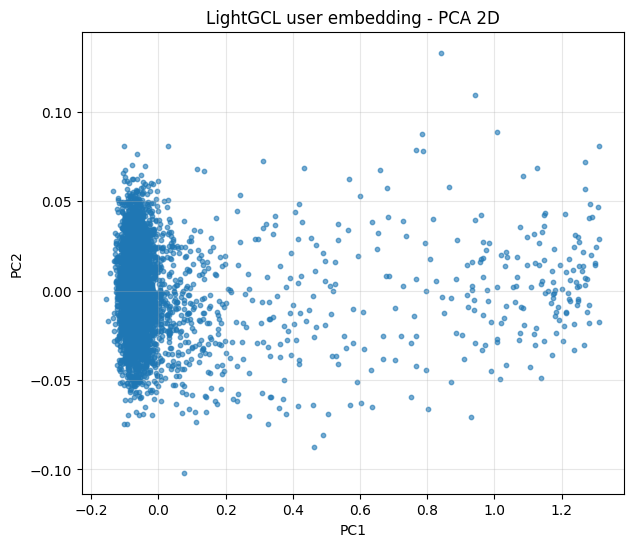

→ PCA explained variance ratio: [0.66603888 0.00724923]


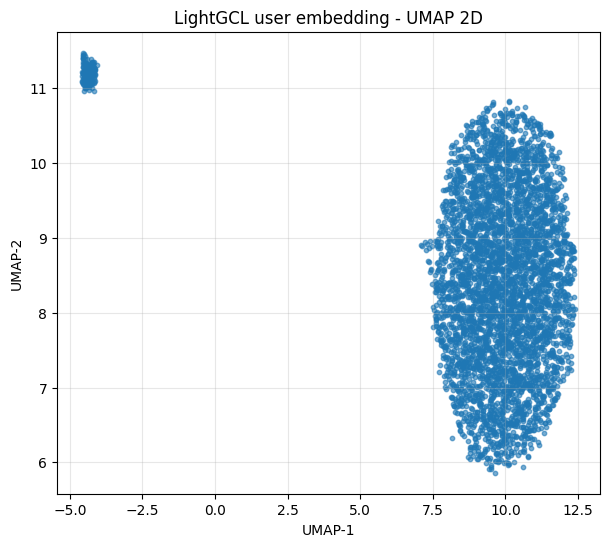

Visualization complete.


In [71]:
visualize_embeddings_2D(user_embeddings, "LightGCL user embedding")

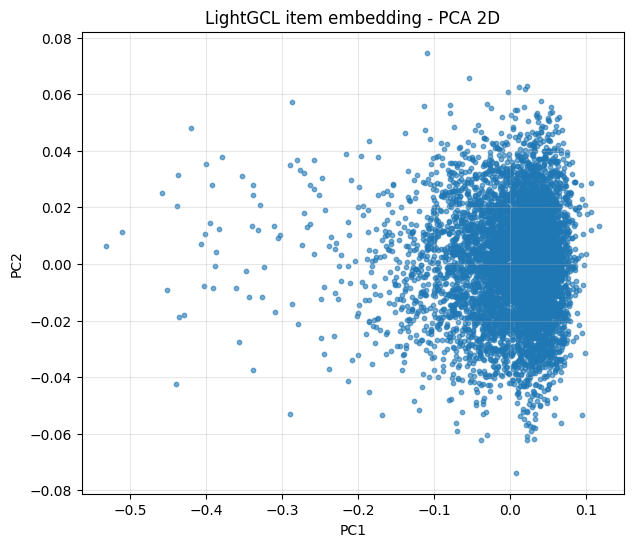

→ PCA explained variance ratio: [0.16200386 0.01630903]


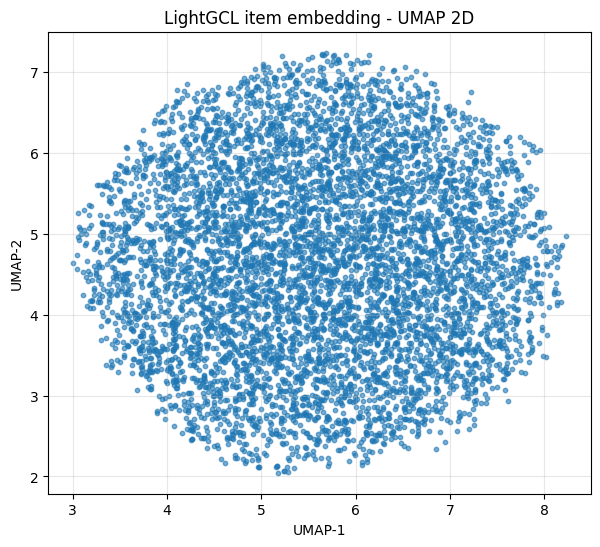

Visualization complete.


In [72]:
visualize_embeddings_2D(item_embeddings, "LightGCL item embedding")

**Inference**

In [73]:
df_rating.head()

,user_id,anime_id,rating,user,anime
0,326,11061,0.888889,0,0
1,326,136,0.888889,0,1
2,326,10408,0.777778,0,2
3,326,256,0.777778,0,3
4,326,11005,0.777778,0,4


In [74]:
df_anime.head()

,anime_id,Score,Genres,Ranked,Popularity,Members,Favorites,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Name,sypnopsis
0,1,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",28.0,39,1251960,61971,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,Cowboy Bebop,"In the year 2071, humanity has colonized sever..."
1,5,8.39,"Action, Drama, Mystery, Sci-Fi, Space",159.0,518,273145,1174,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,Cowboy Bebop: Tengoku no Tobira,"other day, another bounty—such is the life of ..."
2,6,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",266.0,201,558913,12944,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,Trigun,"Vash the Stampede is the man with a $$60,000,0..."
3,7,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",2481.0,1467,94683,587,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,Witch Hunter Robin,ches are individuals with special powers like ...
4,8,6.98,"Adventure, Fantasy, Shounen, Supernatural",3710.0,4369,13224,18,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,Bouken Ou Beet,It is the dark century and the people are suff...


In [75]:
user_id = 326
top_anime = recommend(user_id, model)
print(df_rating[(df_rating['anime_id'].isin(top_anime)) & (df_rating['user_id'] == user_id)][['user_id','anime_id','rating']])
print(df_anime[df_anime['anime_id'].isin(top_anime)][['Score','Genres','anime_id']])

     user_id  anime_id    rating
123      326     15809  0.555556
143      326     31964  0.777778
258      326      5081  0.888889
265      326     22789  0.888889
434      326     11741  0.888889
475      326     16498  0.888889
522      326     28171  0.888889
544      326     31240  1.000000
608      326      4224  0.888889
      Score                                             Genres  anime_id
172    8.83                     Adventure, Supernatural, Drama       199
2158   8.24             Slice of Life, Comedy, Romance, School      4224
2295   8.36            Romance, Supernatural, Mystery, Vampire      5081
3299   8.59               Action, Supernatural, Magic, Fantasy     11741
3670   7.83     Comedy, Demons, Supernatural, Romance, Fantasy     15809
3730   8.48  Action, Military, Mystery, Super Power, Drama,...     16498
4193   8.41                              Comedy, Slice of Life     22789
4475   8.29                             Ecchi, School, Shounen     28171
4732   8.29  